<a href="https://colab.research.google.com/github/IsaacGridGainsDev/IsaacGridGainsDev1/blob/main/Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [56]:
!pip install torchinfo

import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import sklearn.model_selection
import pandas as pd
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
import torchinfo
import torchvision
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, random_split
from torchinfo import summary
from torchvision import datasets, models, transforms
from tqdm import tqdm

In [2]:
#print out the versions of our packages
print("PyTorch version:", torch.__version__)
print("Torch Info version:", torchinfo.__version__)
print("Torchvision version:", torchvision.__version__)
print("Matplotlib version:", matplotlib.__version__)
print("Numpy version:", np.__version__)
!python --version

PyTorch version: 2.6.0+cu124
Torch Info version: 1.8.0
Torchvision version: 0.21.0+cu124
Matplotlib version: 3.10.0
Numpy version: 2.0.2
Python 3.11.12


In [3]:
#we should be running on gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
#we need sample data to train images
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mahmoudreda55/satellite-image-classification")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/satellite-image-classification


In [5]:
data_dir = os.path.join(path, 'data')
print(data_dir)

/kaggle/input/satellite-image-classification/data


In [6]:
#we create a transformation pipeline to standardize our images to RGB and same sizes
class ConvertToRGB:
    def __call__(self, image):
        if image.mode != "RGB":
            image = image.convert("RGB")
        return image

In [7]:
# now we create the set of transformations listed above using means and standard deviations from a previous model
transform = transforms.Compose(
            [
                ConvertToRGB(),
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ]

)

In [8]:
dataset = datasets.ImageFolder(root=data_dir, transform=transform)
dataset

Dataset ImageFolder
    Number of datapoints: 5631
    Root location: /kaggle/input/satellite-image-classification/data
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [9]:
dataset.classes

['cloudy', 'desert', 'green_area', 'water']

In [10]:
# using random_split to create a training and validation dataset
g = torch.Generator().manual_seed(42)

train_dataset, val_dataset = random_split(dataset, [0.8, 0.2], generator=g)

#print lengths of val and train dataset
print("Length of train dataset:", len(train_dataset))
print("Length of validation dataset:", len(val_dataset))

#print percentage of training and validation training
print("Percentage of train dataset:", np.round(100 * len(train_dataset)/len(dataset), 2),'%')
print("Percentage of validation dataset:", np.round(100 * len(val_dataset)/len(dataset), 2),'%')

Length of train dataset: 4505
Length of validation dataset: 1126
Percentage of train dataset: 80.0 %
Percentage of validation dataset: 20.0 %


In [13]:
from training import class_counts

In [14]:
train_counts = class_counts(train_dataset)
train_counts

  0%|          | 0/4505 [00:00<?, ?it/s]

,0
cloudy,1201
desert,888
green_area,1197
water,1219


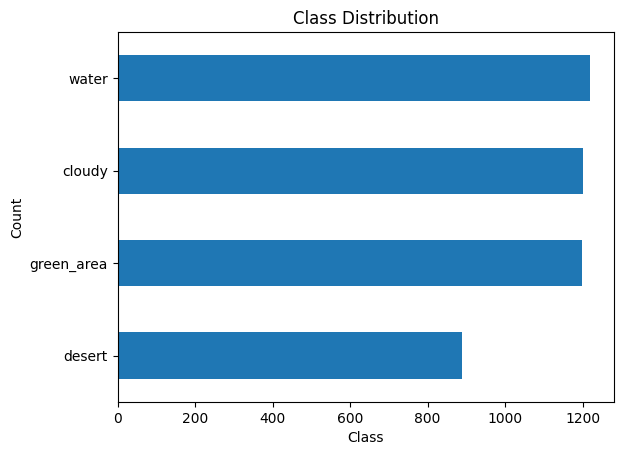

In [15]:
#make a bar chart from the function output
train_counts.sort_values().plot(kind='barh')
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

In [16]:
val_counts = class_counts(val_dataset)
val_counts

  0%|          | 0/1126 [00:00<?, ?it/s]

,0
cloudy,299
desert,243
green_area,303
water,281


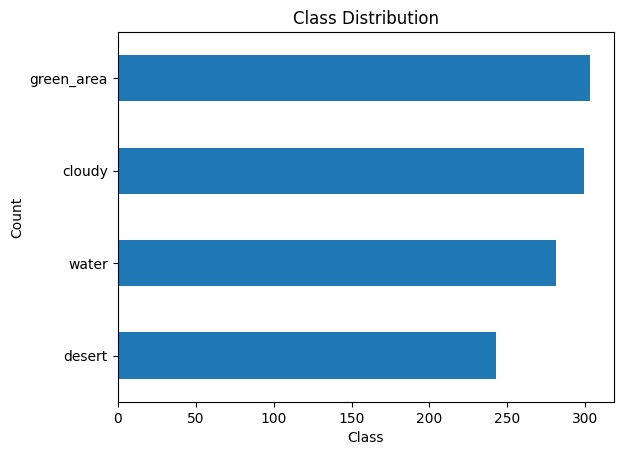

In [17]:
val_counts.sort_values().plot(kind='barh')
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

In [18]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [19]:
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 161MB/s]


In [20]:
# we have to freeze the model parameters
for params in model.parameters():
  params.requires_grad = False
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [21]:
#now we pick the last layer of our model called fc and assign the number of in-features to a variable called in_feat
in_feat = model.fc.in_features
in_feat

2048

In [22]:
#now we can change the last layer to a dense one with 256 neurons, add a ReLU activation, add p=0.5 of dropout, finalized with the output layer of 5 neurons
modified_last_layer = nn.Sequential()
modified_last_layer.append(nn.Linear(in_feat, 256))
modified_last_layer.append(nn.ReLU())
modified_last_layer.append(nn.Dropout(p=0.5))
modified_last_layer.append(nn.Linear(256, 4))

Sequential(
  (0): Linear(in_features=2048, out_features=256, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=256, out_features=4, bias=True)
)

In [23]:
model.fc = modified_last_layer
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [24]:
# now we can train the model
# first, we have to specify our loss function and optimizer with a weight_decay pf 1e-4
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), weight_decay=1e-4)

In [25]:
#print the loss fn and the optimizer
print(loss_fn)
print(optimizer)

CrossEntropyLoss()
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0.0001
)


In [26]:
# we are going to call the summary function on the model using the model itself and size of input sensors as arguments
height = 224
width = 224
channels = 3
summary(model, input_size=(batch_size, channels, width, height))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [32, 4]                   --
├─Conv2d: 1-1                            [32, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [32, 64, 112, 112]        (128)
├─ReLU: 1-3                              [32, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [32, 64, 56, 56]          --
├─Sequential: 1-5                        [32, 256, 56, 56]         --
│    └─Bottleneck: 2-1                   [32, 256, 56, 56]         --
│    │    └─Conv2d: 3-1                  [32, 64, 56, 56]          (4,096)
│    │    └─BatchNorm2d: 3-2             [32, 64, 56, 56]          (128)
│    │    └─ReLU: 3-3                    [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-4                  [32, 64, 56, 56]          (36,864)
│    │    └─BatchNorm2d: 3-5             [32, 64, 56, 56]          (128)
│    │    └─ReLU: 3-6                    [32, 64, 56, 56]   

In [27]:
#training the model with callbacks
#we are going to be using the learning rate scheduler
# we will use the StepLR from torch.optim, set the step_size to4 and gamma factor to 0.2
scheduler = StepLR(optimizer, step_size=4, gamma=0.2)

In [33]:
#now we are going to create the early stopping function with the current val_loss, best_val_loss, and number of epochs since the val_loss last improved(counter)
def early_stopping(val_loss, best_val_loss, counter):
    stop = False
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
    else:
        counter += 1

    #check if counter is >= patience(5 epochs), set stop variable accoringly
    if counter >= 5:
      stop = True
    return counter, stop

In [34]:
#next we define a function that will take care of checkpointing so that if val_loss improves, the model is saved
def checkpointing(val_loss, best_val_loss, model, optimizer, save_path):
  if val_loss < best_val_loss:
    torch.save(
        {
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss
        },
        save_path
    )

    #print a message to notify save path and validation loss
    print(f"Checkpoint saved at {save_path} with val_loss: {val_loss}")

In [35]:
from training import score, train_epoch


def train(
    model,
    optimizer,
    loss_fn,
    train_loader,
    val_loader,
    epochs=20,
    device="cpu",
    scheduler=None,
    checkpoint_path=None,
    early_stopping=None,
):
    # Track the model progress over epochs
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    learning_rates = []

    # Create the trackers if needed for checkpointing and early stopping
    best_val_loss = float("inf")
    early_stopping_counter = 0

    print("Model evaluation before start of training...")
    # Test on training set
    train_loss, train_accuracy = score(model, train_loader, loss_fn, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    # Test on validation set
    validation_loss, validation_accuracy = score(model, val_loader, loss_fn, device)
    val_losses.append(validation_loss)
    val_accuracies.append(validation_accuracy)

    for epoch in range(1, epochs + 1):
        print("\n")
        print(f"Starting epoch {epoch}/{epochs}")

        # Train one epoch
        train_epoch(model, optimizer, loss_fn, train_loader, device)

        # Evaluate training results
        train_loss, train_accuracy = score(model, train_loader, loss_fn, device)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Test on validation set
        validation_loss, validation_accuracy = score(model, val_loader, loss_fn, device)
        val_losses.append(validation_loss)
        val_accuracies.append(validation_accuracy)

        print(f"Epoch: {epoch}")
        print(f"Training loss: {train_loss:.4f}")
        print(f"Training accuracy: {train_accuracy*100:.4f}%")
        print(f"Validation loss: {validation_loss:.4f}")
        print(f"Validation accuracy: {validation_accuracy*100:.4f}%")

        # # Log the learning rate and have the scheduler adjust it
        lr = optimizer.param_groups[0]["lr"]
        learning_rates.append(lr)
        if scheduler:
            scheduler.step()

        # Checkpointing saves the model if current model is better than best so far
        if checkpoint_path:
            checkpointing(
                validation_loss, best_val_loss, model, optimizer, checkpoint_path
            )

        # Early Stopping
        if early_stopping:
            early_stopping_counter, stop = early_stopping(
                validation_loss, best_val_loss, early_stopping_counter
            )
            if stop:
                print(f"Early stopping triggered after {epoch} epochs")
                break

        if validation_loss < best_val_loss:
            best_val_loss = validation_loss

    return (
        learning_rates,
        train_losses,
        val_losses,
        train_accuracies,
        val_accuracies,
        epoch,
    )

In [36]:
epochs_to_train = 50

# Define the checkpoint path
checkpoint_path = "model/LR_model.pth"

# Create the parent directory if it doesn't exist
checkpoint_dir = os.path.dirname(checkpoint_path)
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)


train_results = train(
    model,
    optimizer,
    loss_fn,
    train_loader,
    val_loader,
    epochs=epochs_to_train,
    device=device,
    scheduler=scheduler,
    checkpoint_path="model/LR_model.pth",
    early_stopping=early_stopping,
)

(
    learning_rates,
    train_losses,
    valid_losses,
    train_accuracies,
    valid_accuracies,
    epochs,
) = train_results

Model evaluation before start of training...


Scoring:   0%|          | 0/141 [00:00<?, ?it/s]

Scoring:   0%|          | 0/36 [00:00<?, ?it/s]



Starting epoch 1/50


Training:   0%|          | 0/141 [00:00<?, ?it/s]

Scoring:   0%|          | 0/141 [00:00<?, ?it/s]

Scoring:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch: 1
Training loss: 0.0094
Training accuracy: 99.5567%
Validation loss: 0.0097
Validation accuracy: 97.4826%
Checkpoint saved at model/LR_model.pth with val_loss: 0.009691956498297967


Starting epoch 2/50


Training:   0%|          | 0/141 [00:00<?, ?it/s]

Scoring:   0%|          | 0/141 [00:00<?, ?it/s]

Scoring:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch: 2
Training loss: 0.0063
Training accuracy: 99.6676%
Validation loss: 0.0082
Validation accuracy: 97.4826%
Checkpoint saved at model/LR_model.pth with val_loss: 0.008211203414248303


Starting epoch 3/50


Training:   0%|          | 0/141 [00:00<?, ?it/s]

Scoring:   0%|          | 0/141 [00:00<?, ?it/s]

Scoring:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch: 3
Training loss: 0.0083
Training accuracy: 99.6232%
Validation loss: 0.0098
Validation accuracy: 97.3958%


Starting epoch 4/50


Training:   0%|          | 0/141 [00:00<?, ?it/s]

Scoring:   0%|          | 0/141 [00:00<?, ?it/s]

Scoring:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch: 4
Training loss: 0.0052
Training accuracy: 99.7119%
Validation loss: 0.0045
Validation accuracy: 97.6562%
Checkpoint saved at model/LR_model.pth with val_loss: 0.004452817700035262


Starting epoch 5/50


Training:   0%|          | 0/141 [00:00<?, ?it/s]

Scoring:   0%|          | 0/141 [00:00<?, ?it/s]

Scoring:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch: 5
Training loss: 0.0063
Training accuracy: 99.7119%
Validation loss: 0.0076
Validation accuracy: 97.4826%


Starting epoch 6/50


Training:   0%|          | 0/141 [00:00<?, ?it/s]

Scoring:   0%|          | 0/141 [00:00<?, ?it/s]

Scoring:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch: 6
Training loss: 0.0042
Training accuracy: 99.7562%
Validation loss: 0.0042
Validation accuracy: 97.6562%
Checkpoint saved at model/LR_model.pth with val_loss: 0.004240344801979113


Starting epoch 7/50


Training:   0%|          | 0/141 [00:00<?, ?it/s]

Scoring:   0%|          | 0/141 [00:00<?, ?it/s]

Scoring:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch: 7
Training loss: 0.0036
Training accuracy: 99.7784%
Validation loss: 0.0045
Validation accuracy: 97.6562%


Starting epoch 8/50


Training:   0%|          | 0/141 [00:00<?, ?it/s]

Scoring:   0%|          | 0/141 [00:00<?, ?it/s]

Scoring:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch: 8
Training loss: 0.0042
Training accuracy: 99.7562%
Validation loss: 0.0057
Validation accuracy: 97.5694%


Starting epoch 9/50


Training:   0%|          | 0/141 [00:00<?, ?it/s]

Scoring:   0%|          | 0/141 [00:00<?, ?it/s]

Scoring:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch: 9
Training loss: 0.0039
Training accuracy: 99.7784%
Validation loss: 0.0057
Validation accuracy: 97.4826%


Starting epoch 10/50


Training:   0%|          | 0/141 [00:00<?, ?it/s]

Scoring:   0%|          | 0/141 [00:00<?, ?it/s]

Scoring:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch: 10
Training loss: 0.0051
Training accuracy: 99.7119%
Validation loss: 0.0048
Validation accuracy: 97.5694%


Starting epoch 11/50


Training:   0%|          | 0/141 [00:00<?, ?it/s]

Scoring:   0%|          | 0/141 [00:00<?, ?it/s]

Scoring:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch: 11
Training loss: 0.0045
Training accuracy: 99.7784%
Validation loss: 0.0046
Validation accuracy: 97.5694%
Early stopping triggered after 11 epochs


In [37]:
print(f"Training went on for {epochs} number of epochs before it stopped.")

Training went on for 11 number of epochs before it stopped.


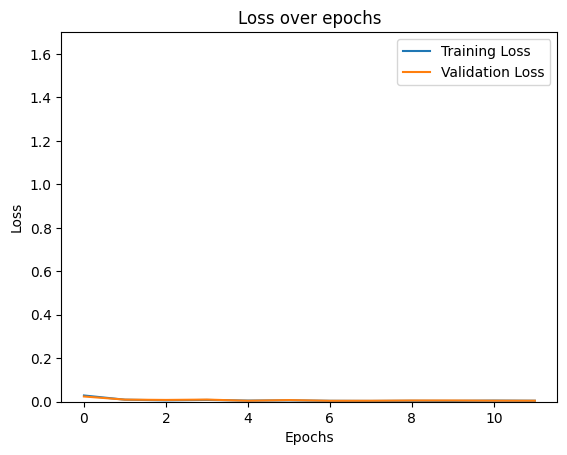

In [40]:
plt.plot(train_losses, label="Training Loss")
plt.plot(valid_losses, label="Validation Loss")
plt.ylim([0, 1.7])
plt.title("Loss over epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend();

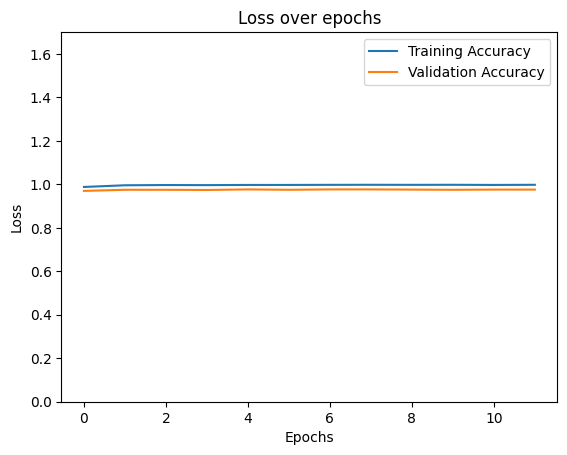

In [41]:
plt.plot(train_accuracies, label="Training Accuracy")
plt.plot(valid_accuracies, label="Validation Accuracy")
plt.ylim([0, 1.7])
plt.title("Loss over epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend();

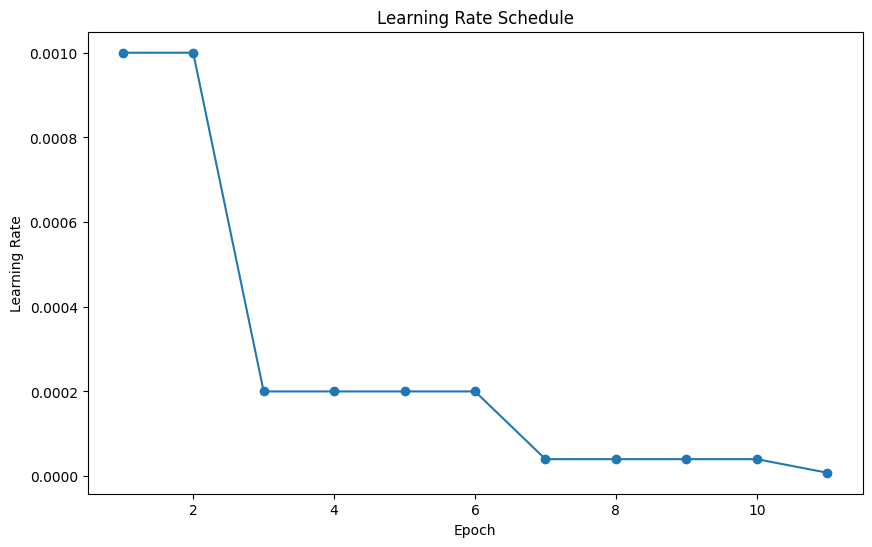

In [42]:
# Plot the learning rates
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), learning_rates, marker="o", label="Learning Rate")
plt.title("Learning Rate Schedule")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.show()

In [43]:
checkpoint = torch.load("model/LR_model.pth")

# Load the state dictionaries
model.load_state_dict(checkpoint["model_state_dict"])
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

In [44]:
from training import predict

probabilities_val = predict(model, val_loader, device)
predictions_val = torch.argmax(probabilities_val, dim=1)

print(predictions_val)

Predicting:   0%|          | 0/36 [00:00<?, ?it/s]

tensor([0, 1, 1,  ..., 1, 0, 0], device='cuda:0')


In [53]:
classes = os.listdir(data_dir)
targets_val = torch.cat([labels for _, labels in tqdm(val_loader, desc="Get Labels")])

cm = confusion_matrix(targets_val.cpu(), predictions_val.cpu())

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)

# Set figure size
plt.figure(figsize=(10, 8))


Get Labels: 100%|██████████| 36/36 [00:04<00:00,  7.90it/s]


<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

In [54]:
model.to(device)


def file_to_confidence(model, datadir, filename, transform_pipeline):
    file_path = os.path.join(datadir, filename)
    image = PIL.Image.open(file_path)
    transformed = transform_pipeline(image)
    unsqueezed = transformed.unsqueeze(0)
    image_cuda = unsqueezed.to(device)

    model.eval()
    with torch.no_grad():
        model_raw = model(image_cuda)
        confidence = torch.nn.functional.softmax(model_raw, dim=1)

    conf_df = pd.DataFrame([[filename] + confidence.tolist()[0]])
    conf_df.columns = ["ID"] + train_dataset.dataset.classes

    return conf_df

In [58]:
# prompt: create a test directory with a healty mix of images from the four classes

import random
import shutil

test_dir = "test_images"
os.makedirs(test_dir, exist_ok=True)

# Get all image paths
all_image_paths = []
for class_name in classes:
    class_dir = os.path.join(data_dir, class_name)
    image_files = [f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))]
    all_image_paths.extend([os.path.join(class_dir, f) for f in image_files])

# Randomly select a subset of images for the test set (e.g., 100 images)
num_test_images_per_class = 25 # Adjust this number as needed
selected_image_paths = []

for class_name in classes:
    class_dir = os.path.join(data_dir, class_name)
    image_files = [f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))]
    # Shuffle the list of image files for the current class
    random.shuffle(image_files)
    # Select a specified number of images from this class
    selected_images_for_class = image_files[:num_test_images_per_class]
    selected_image_paths.extend([os.path.join(class_dir, f) for f in selected_images_for_class])

# Copy the selected images to the test directory
for img_path in selected_image_paths:
    shutil.copy(img_path, test_dir)

print(f"Created test directory '{test_dir}' with {len(selected_image_paths)} images.")
# You can verify the contents of the test directory
!ls test_images

Created test directory 'test_images' with 100 images.
'desert(1045).jpg'   Forest_1464.jpg   SeaLake_1095.jpg   train_11161.jpg
'desert(112).jpg'    Forest_1940.jpg   SeaLake_1126.jpg   train_11673.jpg
'desert(139).jpg'    Forest_2022.jpg   SeaLake_1646.jpg   train_12682.jpg
'desert(226).jpg'    Forest_2040.jpg   SeaLake_1680.jpg   train_13078.jpg
'desert(233).jpg'    Forest_2104.jpg   SeaLake_1786.jpg   train_13114.jpg
'desert(260).jpg'    Forest_2229.jpg   SeaLake_2029.jpg   train_14654.jpg
'desert(28).jpg'     Forest_2279.jpg   SeaLake_2226.jpg   train_1483.jpg
'desert(321).jpg'    Forest_2318.jpg   SeaLake_2231.jpg   train_16418.jpg
'desert(376).jpg'    Forest_2607.jpg   SeaLake_2275.jpg   train_1663.jpg
'desert(394).jpg'    Forest_2751.jpg   SeaLake_2480.jpg   train_17513.jpg
'desert(490).jpg'    Forest_308.jpg    SeaLake_2514.jpg   train_18150.jpg
'desert(507).jpg'    Forest_324.jpg    SeaLake_2538.jpg   train_24490.jpg
'desert(533).jpg'    Forest_385.jpg    SeaLake_2839.jpg   tr

In [59]:
small_dfs = []

for filename in tqdm(os.listdir(test_dir), desc="Predicting on test set"):
    small_dfs.append(
        file_to_confidence(model, test_dir, filename, transform)
    )

confidence_df = pd.concat(small_dfs)

confidence_df = confidence_df.sort_values("ID").reset_index(drop=True)
confidence_df.head()

Predicting on test set: 100%|██████████| 100/100 [00:02<00:00, 34.93it/s]


,ID,cloudy,desert,green_area,water
0,Forest_1464.jpg,2.720728e-05,5.251387e-05,0.999374,0.000546
1,Forest_1940.jpg,1.409701e-05,3.260256e-06,0.999120,0.000863
2,Forest_2022.jpg,1.715185e-05,8.451040e-07,0.994750,0.005232
3,Forest_2040.jpg,6.278940e-07,8.938712e-07,0.999987,0.000011
4,Forest_2104.jpg,4.315104e-06,1.090285e-06,0.999957,0.000038


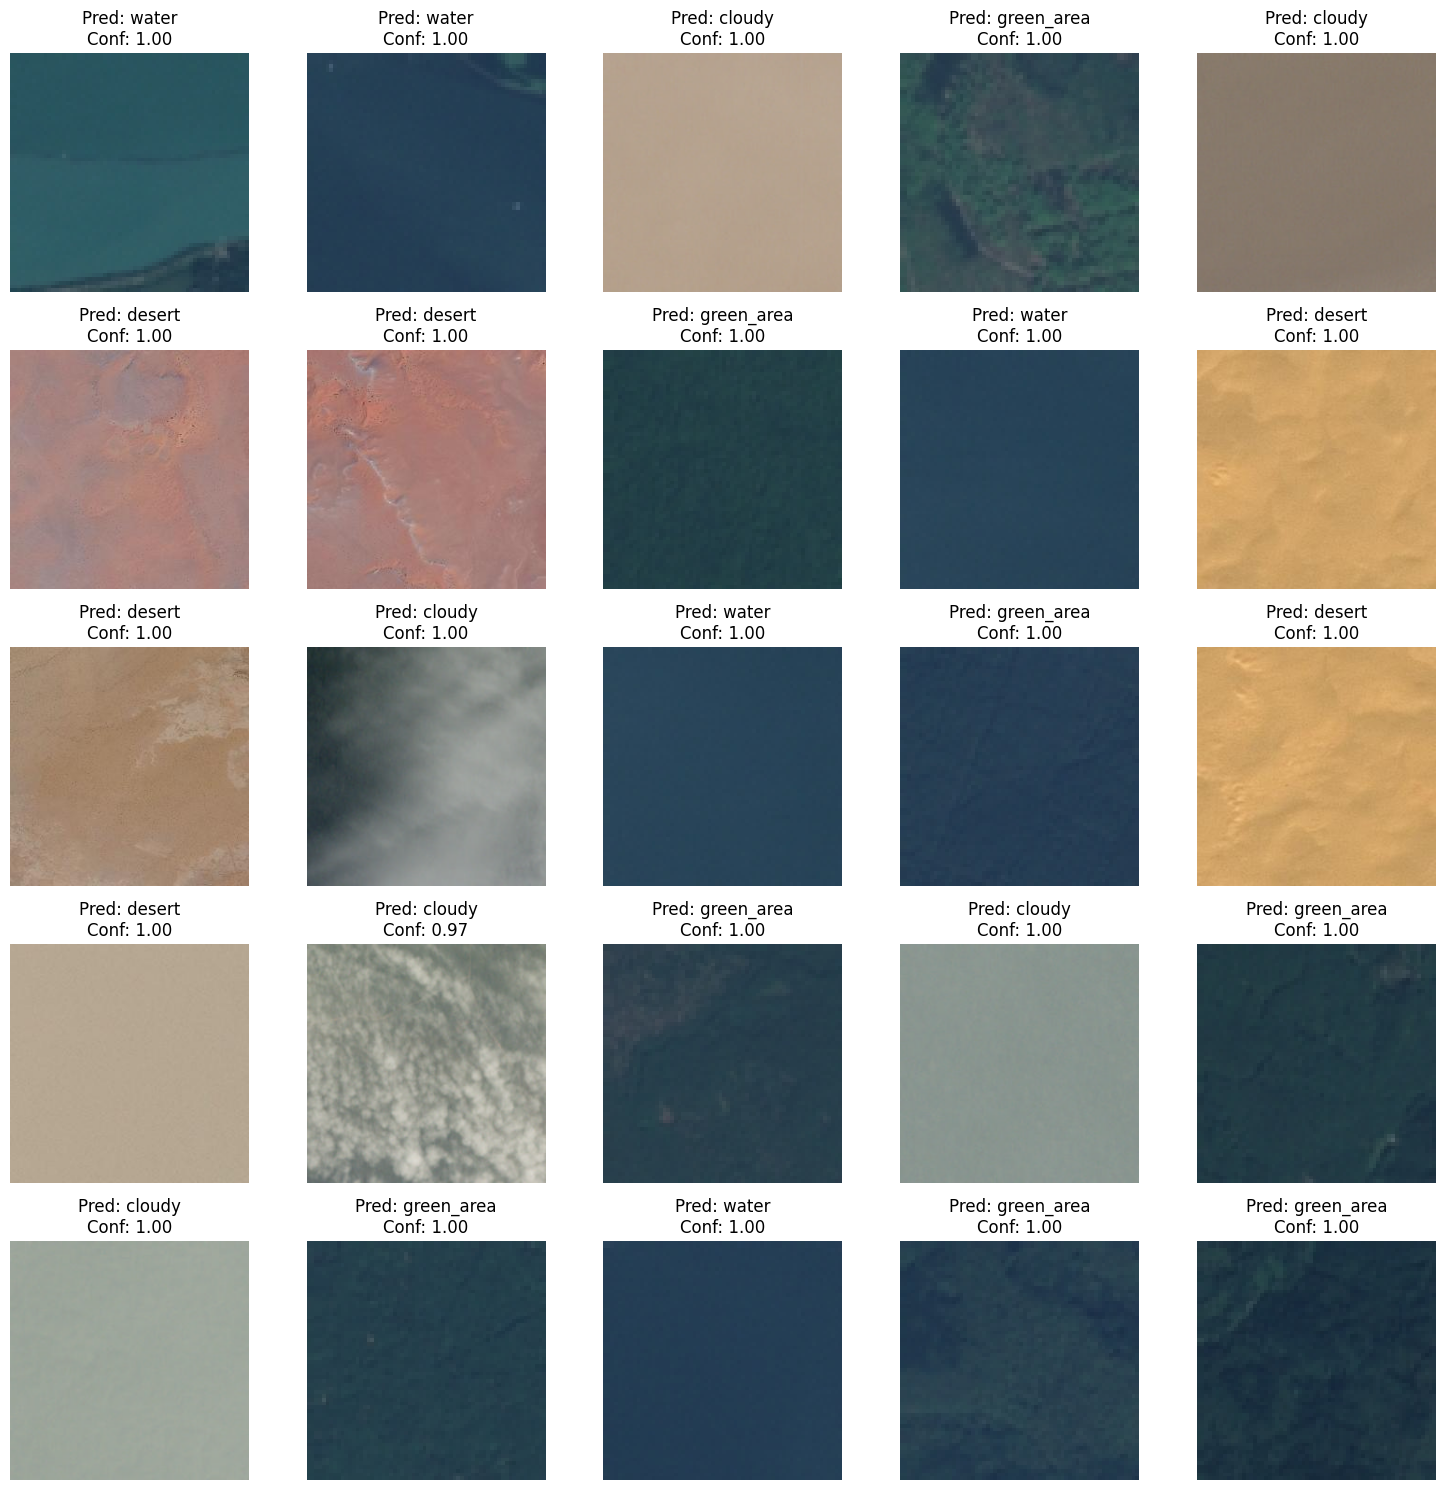

In [60]:
# prompt: show a 5 x 5 grid of images from the test sets and use the model to prdict what class it is

import matplotlib.pyplot as plt
# Select a 5x5 grid of images from the test set
num_images = 25
test_images = os.listdir(test_dir)
if len(test_images) < num_images:
    print(f"Warning: Not enough images in the test directory ({len(test_images)} available). Displaying all available images.")
    selected_test_images = test_images
else:
    selected_test_images = random.sample(test_images, num_images)

# Plot the images with predictions
fig, axes = plt.subplots(5, 5, figsize=(15, 15))
axes = axes.ravel() # Flatten the axes array for easy iteration

for i, img_name in enumerate(selected_test_images):
    img_path = os.path.join(test_dir, img_name)
    image = PIL.Image.open(img_path)

    # Get the prediction for the current image
    conf_df = file_to_confidence(model, test_dir, img_name, transform)
    predicted_class_index = conf_df.drop('ID', axis=1).values.argmax()
    predicted_class = dataset.classes[predicted_class_index]
    confidence_score = conf_df.drop('ID', axis=1).values.max()

    axes[i].imshow(image)
    axes[i].set_title(f"Pred: {predicted_class}\nConf: {confidence_score:.2f}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [61]:
confidence_df.to_csv("submission.csv", index=False)